# Examining Gender Difference in Mean Finishing Time for a 5K

In this notebook, I will be using pandas and data scraped from the Nittany Valley Running Club at https://www.nvrun.com/ to run a permutation-based hypothesis test and a bootstrapped confidence interval to determine if there is a statistically significant difference in the average finishing time of runners who identify as female and those who do not.


In [ ]:
import pandas as pd
import numpy as np
path = "https://raw.githubusercontent.com/DS200-SP2024-Hunter/Lab08-DueMar20/main/FiveKResults.csv"

First, let's load in the data.

In [ ]:
fiveK = pd.read_csv(path)
fiveK.head()

,Run,Finishing Time In Minutes,Identifies As Female,Age,Name,City,State
0,AF,17.617,False,27,Andy Cunningham,State College,PA
1,AF,18.067,False,49,S Mark Courtney,Grove City,PA
2,AF,18.583,False,46,Terry Reid,Bellefonte,PA
3,AF,18.717,False,15,Justin Rupert,Wellsboro,PA
4,AF,18.800,True,35,Kate Fonshell,Ardmore,PA


Now, let's simplify our data into a new dataframe with just the time and whether or not the runner identifies as a female.

In [ ]:
new_5k = fiveK.copy()[['Finishing Time In Minutes', 'Identifies As Female']]
new_5k.head()

,Finishing Time In Minutes,Identifies As Female
0,17.617,False
1,18.067,False
2,18.583,False
3,18.717,False
4,18.800,True


Let's find the population difference of means by gender for a p-value calculation later. Let's also create a function so we can use it later in A/B testing.

In [ ]:
def difference_of_means(df):
    new_df = df.groupby('Identifies As Female').mean()
    return new_df.loc[False][0] - new_df.loc[True][0] #non-female - female

observed_difference = difference_of_means(new_5k)

In [ ]:
observed_difference

-4.5908775279948095

This means that the mean time of a non-female is 4.59 minutes faster than a female in this dataset. Next, we need to find out whether this is just due to chance in this dataset, or if there is a statistically significant difference in the means and we can apply this finding to a population greater than just the sample.

##A/B Test

To find this out, let's run an A/B test. The null hypothesis is that there is no difference in the mean finish race time of those who identify as women and the rest of the field of runners. We will set the necessary p-value to reject the null at .05

In [ ]:
def one_simulated_difference_of_means():
    shuffled_labels = new_5k['Identifies As Female'].sample(n = 656, replace=False).reset_index(drop=True) #randomly shuffles the values of True and False
    new_5k['Identifies As Female'] = shuffled_labels
    return difference_of_means(new_5k)

one_simulated_difference_of_means()

-0.6615880837540757

For our next step. We will run the simulated difference of means under the assumption of the null hypothesis 5000 times to eventually compare our observed difference of means from the dataset.

In [ ]:
repetitions = 5000
differences = np.empty(repetitions)

for i in np.arange(repetitions):
    differences[i] = one_simulated_difference_of_means()

In [ ]:
differences[0:10]

array([-0.39307334, -0.19958359, -0.41303231,  0.17034196,  0.00123966,
        0.92972646,  0.20899551, -0.85143883, -0.30561407,  1.03074253])

Next, let's plot the 5000 repetitions on a histogram.



array([[<Axes: title={'center': '0'}>]], dtype=object)

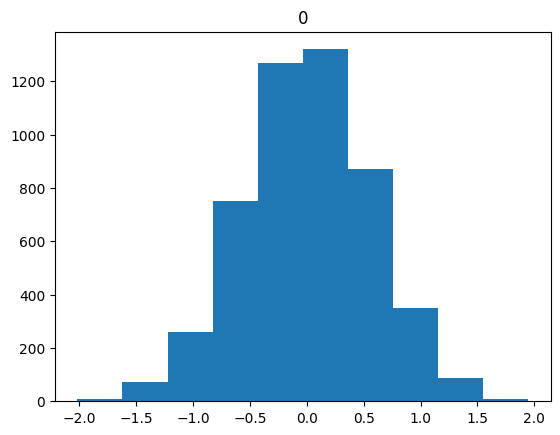

In [ ]:
pd.DataFrame(differences).hist(grid=False)

If you remember, our observed statistic was about -4.6. As you can see above, neither extremes on the left or the right surpass a simulated difference of -2.1. To be sure, let's calculate the p-value. We will stick with a two-sided p-value because we are testing to see if there is "any" difference between the two populations despite what some assumptions about running and biology may lead you to think.

In [ ]:
diff_array = np.array(differences)
p_value = np.count_nonzero(abs(diff_array)>=abs(observed_difference))/repetitions
p_value

0.0

English Conclusion: After 5,000 repititions assuming that there is no difference in the average finishing time of runners who identify as female and those who do not, there was not a single repitition in which we saw a point as extreme as what we saw in the sample race. Thus, we can say that our evidence leads to the fact that the reason for this observed difference is something other than random chance.

Statistical Conclusion: With a p-value of 0, we can reject our null hypothesis that there is no difference in the mean finishing time of runners who identify as female and those who do not. The p-value signifies that there is no value as extreme or more extreme in the simulation as the original sample statistic.

## Bootstrapping a Confidence Interval

When constructing our confidence interval, it's important that each sample we take has the same number as the original sample. Let's see if those values are different:

In [ ]:
fiveK['Identifies As Female'].value_counts()

False    363
True     293
Name: Identifies As Female, dtype: int64

Clearly there are more non-female identifying runners in the sample, so we can split the dataframe into two different dataframes to simplify our next steps.

In [ ]:
fiveK_male = fiveK[fiveK['Identifies As Female']==False]
fiveK_female = fiveK[fiveK['Identifies As Female']==True]

Now, let's create a function for a single bootstrapped mean. This includes creating a sample (with replacement) for both females and non-females and then finding the difference.

In [ ]:
def one_bootstrap_mean_difference():
    resampled_Females = fiveK_female.sample(n = 293, replace = True)
    resampled_Males = fiveK_male.sample(n = 363, replace = True)
    Female_mean = np.mean(resampled_Females['Finishing Time In Minutes'])
    Male_mean = np.mean(resampled_Males['Finishing Time In Minutes'])
    bootstrapped_mean_difference =  Male_mean - Female_mean
    return bootstrapped_mean_difference
one_bootstrap_mean_difference()

-4.8744071775778295

The next step in our analysis is to create a histogram with 5000 bootstrapped sample mean differences.

In [ ]:
num_repetitions = 5000
bstrap_means = list()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean_difference())

array([[<Axes: title={'center': 'Bootstrap Sample means'}>]], dtype=object)

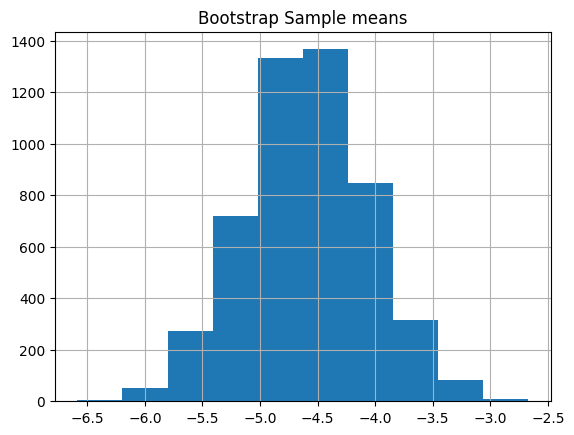

In [ ]:
resampled_means = pd.DataFrame({"Bootstrap Sample means": bstrap_means})
resampled_means.hist()

With this information, we can create a confidence interval by finding the data point at the 2.5 percentile and the 97.5 percentile.

In [ ]:
left = np.percentile(bstrap_means, 2.5)
right = np.percentile(bstrap_means, 97.5)
print(left, "  ", right)

-5.64956784146147    -3.51850233172557


Thus, we are 95% confident that the true difference in mean 5K road race finishing times between females and males is between -5.65 and -3.52.